In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import joblib
import pymysql

In [2]:
df = pd.read_csv('tel_churn_dataset.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243553 entries, 0 to 243552
Data columns (total 19 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   customer_id           243553 non-null  int64 
 1   telecom_partner       243553 non-null  object
 2   gender                243553 non-null  object
 3   age                   243553 non-null  int64 
 4   state                 243553 non-null  object
 5   city                  243553 non-null  object
 6   pincode               243553 non-null  int64 
 7   date_of_registration  243553 non-null  object
 8   num_dependents        243553 non-null  int64 
 9   estimated_salary      243553 non-null  int64 
 10  calls_made            243553 non-null  int64 
 11  sms_sent              243553 non-null  int64 
 12  data_used             243553 non-null  int64 
 13  Tenure_Months         243553 non-null  int64 
 14  Internet_Type         243553 non-null  object
 15  Subscription_Type

In [3]:
df.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,Tenure_Months,Internet_Type,Subscription_Type,Contract_Type,Payment_Method,churn
0,1,Reliance Jio,F,25,Karnataka,Kolkata,755597,01-01-2020,4,124962,44,45,361,64,Fiber Optic,Basic,One Year,Credit Card,0
1,2,Reliance Jio,F,55,Mizoram,Mumbai,125926,01-01-2020,2,130556,62,39,5973,64,DSL,Premium,One Year,Bank Withdrawal,0
2,3,Vodafone,F,57,Arunachal Pradesh,Delhi,423976,01-01-2020,0,148828,49,24,193,64,DSL,Basic,Two Year,Credit Card,1
3,4,BSNL,M,46,Tamil Nadu,Kolkata,522841,01-01-2020,1,38722,80,25,9377,64,DSL,Basic,One Year,Bank Withdrawal,1
4,5,BSNL,F,26,Tripura,Delhi,740247,01-01-2020,2,55098,78,15,1393,64,Fiber Optic,Basic,Two Year,Credit Card,0


In [4]:
df.isnull().sum()

customer_id             0
telecom_partner         0
gender                  0
age                     0
state                   0
city                    0
pincode                 0
date_of_registration    0
num_dependents          0
estimated_salary        0
calls_made              0
sms_sent                0
data_used               0
Tenure_Months           0
Internet_Type           0
Subscription_Type       0
Contract_Type           0
Payment_Method          0
churn                   0
dtype: int64

In [5]:
df['date_of_registration'] = pd.to_datetime(df['date_of_registration'], errors='coerce')
df.drop(columns = ['customer_id','date_of_registration','pincode','city','state'],inplace = True)

In [6]:
categorical_cols = ["gender", "telecom_partner", "Subscription_Type", "Internet_Type", "Contract_Type", "Payment_Method"]
df[categorical_cols] = df[categorical_cols].astype(str)

encoder = LabelEncoder()
df["gender"] = encoder.fit_transform(df["gender"])
df = pd.get_dummies(df, columns=["telecom_partner", "Subscription_Type", "Internet_Type", "Contract_Type", "Payment_Method"], drop_first=True)


In [7]:

numerical_cols = ["age", "estimated_salary", "calls_made", "sms_sent", "data_used", "Tenure_Months"]
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

In [8]:
X = df.drop(columns=["churn"]) 
y = df["churn"]
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

print("Class distribution after oversampling:\n", y_resampled.value_counts())


Class distribution after oversampling:
 churn
0    194726
1    194726
Name: count, dtype: int64


In [9]:

models = {
    "RandomForest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "GradientBoosting": GradientBoostingClassifier(),
    "LogisticRegression": LogisticRegression()
}

param_grid = {
    "RandomForest": {"n_estimators": [50, 100], "max_depth": [10, 20]},
    "XGBoost": {"n_estimators": [50, 100], "max_depth": [3, 6]},
    "GradientBoosting": {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]},
    "LogisticRegression": {"C": [0.1, 1, 10]}
}

best_model = None
best_score = 0
best_model_name = ""



In [10]:
for name, model in models.items():
    print(f"Training {name}...")
    grid_search = GridSearchCV(model, param_grid[name], cv=3, scoring='roc_auc', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    best_estimator = grid_search.best_estimator_
    
    y_pred = best_estimator.predict(X_test)
    auc = roc_auc_score(y_test, best_estimator.predict_proba(X_test)[:, 1])
    f1 = f1_score(y_test, y_pred)
    
    print(f"{name} - AUC: {auc:.4f}, F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred))
    
    if auc > best_score:
        best_score = auc
        best_model = best_estimator
        best_model_name = name

print(f"\n Best Model: {best_model_name} with AUC {best_score:.4f}")


joblib.dump(best_model, "best_churnn_model.pkl")
print(" Best model saved as 'best_churnn_model.pkl'")
joblib.dump(list(X_train.columns), "traineed_features.pkl")

Training RandomForest...
RandomForest - AUC: 0.7645, F1-score: 0.7067
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     39083
           1       0.65      0.77      0.71     38808

    accuracy                           0.68     77891
   macro avg       0.69      0.68      0.68     77891
weighted avg       0.69      0.68      0.68     77891

Training XGBoost...


C:\Users\darshini\.anaconda\New folder\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:50:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost - AUC: 0.8692, F1-score: 0.8317
              precision    recall  f1-score   support

           0       0.78      1.00      0.87     39083
           1       1.00      0.71      0.83     38808

    accuracy                           0.86     77891
   macro avg       0.89      0.86      0.85     77891
weighted avg       0.89      0.86      0.85     77891

Training GradientBoosting...
GradientBoosting - AUC: 0.7614, F1-score: 0.7059
              precision    recall  f1-score   support

           0       0.72      0.59      0.65     39083
           1       0.65      0.77      0.71     38808

    accuracy                           0.68     77891
   macro avg       0.69      0.68      0.68     77891
weighted avg       0.69      0.68      0.68     77891

Training LogisticRegression...
LogisticRegression - AUC: 0.5656, F1-score: 0.5555
              precision    recall  f1-score   support

           0       0.55      0.52      0.54     39083
           1       0.54      0.57    

['traineed_features.pkl']

In [11]:
test = pd.read_csv('test_customer.csv')
test.head()

,customer_id,telecom_partner,gender,age,state,city,pincode,date_of_registration,num_dependents,estimated_salary,calls_made,sms_sent,data_used,churn
0,243554,Reliance Jio,Male,28,Maharashtra,Mumbai,400001,15-01-2023,2,45000,120,50,3.2 GB,?
1,243555,Airtel,Female,34,Karnataka,Bengaluru,560001,20-11-2022,1,65000,80,30,2.8 GB,?
2,243556,Vodafone Idea,Male,40,Tamil Nadu,Chennai,600001,10-07-2021,3,70000,150,40,4.1 GB,?
3,243557,BSNL,Female,22,Kerala,Kochi,682001,05-05-2023,0,35000,60,20,1.5 GB,?
4,243558,Jio,Male,50,Delhi,New Delhi,110001,15-12-2020,2,90000,200,60,5.2 GB,?


In [12]:

model = joblib.load("best_churnn_model.pkl")
trained_features = joblib.load("traineed_features.pkl")
test_data = pd.read_csv("test_customer.csv")
customer_ids = test_data["customer_id"]
X_test = test_data.drop(columns=["customer_id"])
X_test = pd.get_dummies(X_test)
X_test = X_test.reindex(columns=trained_features, fill_value=0)  # Fill missing features with 0
probabilities = model.predict_proba(X_test)[:, 1]
threshold = 0.3
predictions = (probabilities > threshold).astype(int)
test_data["Churn Probability"] = probabilities
test_data["Churn Prediction"] = ["Yes (Will Churn)" if p == 1 else "No (Will Stay)" for p in predictions]
output = test_data[["customer_id", "Churn Probability", "Churn Prediction"]]
print(output)


output.to_csv("test_customer_predictions.csv", index=False)
print("\n Predictions saved to test_customer_predictions.csv")


   customer_id  Churn Probability  Churn Prediction
0       243554           0.527451  Yes (Will Churn)
1       243555           0.553806  Yes (Will Churn)
2       243556           0.553806  Yes (Will Churn)
3       243557           0.577234  Yes (Will Churn)
4       243558           0.553806  Yes (Will Churn)

 Predictions saved to test_customer_predictions.csv


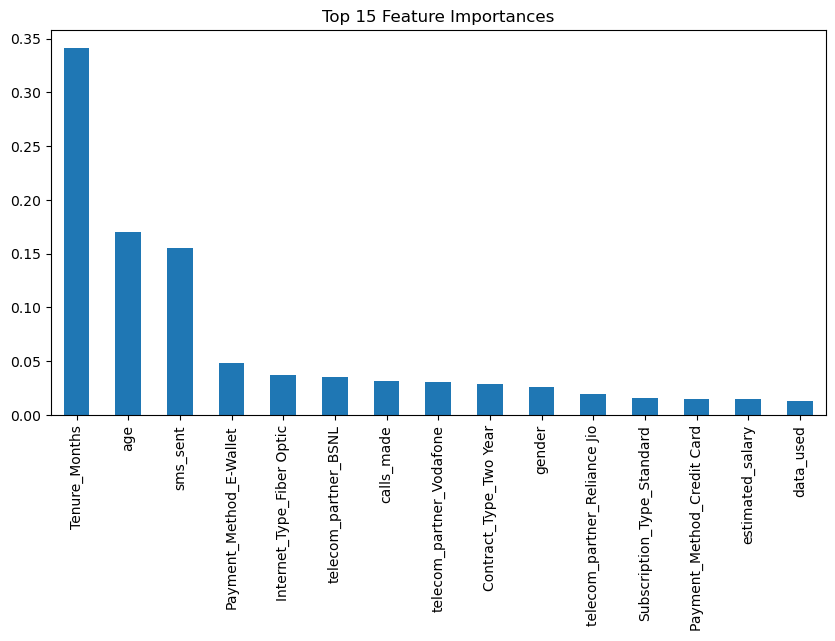

In [13]:
# Feature importance analysis
feature_importances = pd.Series(best_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
feature_importances[:15].plot(kind="bar", figsize=(10,5), title="Top 15 Feature Importances")
plt.show()

In [14]:
df_original = pd.read_csv("tel_churn_dataset.csv")
df = df_original.copy()
trained_features = joblib.load("traineed_features.pkl")
model = joblib.load("best_churnn_model.pkl")

X = df.drop(columns=["customer_id", "churn"], errors="ignore")  
X = pd.get_dummies(X, columns=["telecom_partner", "Subscription_Type", "Internet_Type", "Contract_Type", "Payment_Method"], drop_first=True)


In [16]:

for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype("category").cat.codes

traineed_features = joblib.load("traineed_features.pkl")
missing_cols = set(traineed_features) - set(X.columns)
for col in missing_cols:
    print(f" Missing column: {col}, adding with default value 0")
    X[col] = 0  

X = X[traineed_features]

df["Churn_Prediction"] = model.predict(X)
df["Churn_Probability"] = model.predict_proba(X)[:, 1]

output_file = "churnn_predictions.csv"
df.to_csv(output_file, index=False)
print(f" Predictions saved successfully! File: {output_file}")


 Predictions saved successfully! File: churnn_predictions.csv


In [19]:

df = pd.read_csv("churnn_predictions.csv")

df["date_of_registration"] = pd.to_datetime(df["date_of_registration"], format="%d-%m-%Y").dt.strftime("%Y-%m-%d")

df["Churn_Prediction"] = df["Churn_Prediction"].map({1: "Yes", 0: "No"})

db_config = {
    'host': 'localhost',
    'user': 'root',
    'password': 'Darsh#2004##',
    'database': 'churn_model'
}

try:
    connection = pymysql.connect(**db_config)
    cursor = connection.cursor()

    
    insert_query = """
    INSERT INTO churn_predictions (
        customer_id, telecom_partner, gender, age, state, city, pincode, date_of_registration, 
        num_dependents, estimated_salary, calls_made, sms_sent, data_used, tenure_months, 
        subscription_type, internet_type, contract_type, payment_method, churn, churn_prediction, churn_probability
    ) VALUES (%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
    ON DUPLICATE KEY UPDATE 
        churn_prediction = VALUES(churn_prediction),
        churn_probability = VALUES(churn_probability);
    """

    
    values = df.values.tolist()

    # Insert data into MySQL
    cursor.executemany(insert_query, values)
    connection.commit()
    
    print("✅ Churn predictions successfully inserted into MySQL!")

except Exception as e:
    print(f"❌ Error: {e}")

finally:
    cursor.close()
    connection.close()


✅ Churn predictions successfully inserted into MySQL!
